#Libraries

In [ ]:
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import math
import os
import torch
import sys
import time
import torch.nn.functional as F
import torchvision
import tabulate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.nn import Module, Parameter
from torch.nn.modules.utils import _pair
from scipy.special import binom

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Functions

In [ ]:
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def cyclic_learning_rate(epoch, cycle, alpha_1, alpha_2):
    def schedule(iter):
        t = ((epoch % cycle) + iter) / cycle
        if t < 0.5:
            return alpha_1 * (1.0 - 2.0 * t) + alpha_2 * 2.0 * t
        else:
            return alpha_1 * (2.0 * t - 1.0) + alpha_2 * (2.0 - 2.0 * t)
    return schedule

def save_checkpoint(dir, epoch, **kwargs):
    state = {
        'epoch': epoch,
    }
    state.update(kwargs)
    filepath = os.path.join(dir, 'checkpoint-%d.pt' % epoch)
    torch.save(state, filepath)


def train_epoch(loader, model, criterion, optimizer):
    loss_sum = 0.0
    correct = 0.0

    model.train()

    for i, (input, target) in enumerate(loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        output = model(input_var)
        loss = criterion(output, target_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * input.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target_var.data.view_as(pred)).sum().item()

    return {
        'loss': loss_sum / len(loader.dataset),
        'accuracy': correct / len(loader.dataset) * 100.0,
    }


def eval(loader, model, criterion):
    loss_sum = 0.0
    correct = 0.0

    model.eval()

    for i, (input, target) in enumerate(loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        output = model(input_var)
        loss = criterion(output, target_var)

        loss_sum += loss.item() * input.size(0)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target_var.data.view_as(pred)).sum().item()

    return {
        'loss': loss_sum / len(loader.dataset),
        'accuracy': correct / len(loader.dataset) * 100.0,
    }


import numpy as np
import os
import torch
import torch.nn.functional as F


def l2_regularizer(weight_decay):
    def regularizer(model):
        l2 = 0.0
        for p in model.parameters():
            l2 += torch.sqrt(torch.sum(p ** 2))
        return 0.5 * weight_decay * l2
    return regularizer


def cyclic_learning_rate(epoch, cycle, alpha_1, alpha_2):
    def schedule(iter):
        t = ((epoch % cycle) + iter) / cycle
        if t < 0.5:
            return alpha_1 * (1.0 - 2.0 * t) + alpha_2 * 2.0 * t
        else:
            return alpha_1 * (2.0 * t - 1.0) + alpha_2 * (2.0 - 2.0 * t)
    return schedule


def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


def save_checkpoint(dir, epoch, name='checkpoint', **kwargs):
    state = {
        'epoch': epoch,
    }
    state.update(kwargs)
    filepath = os.path.join(dir, '%s-%d.pt' % (name, epoch))
    torch.save(state, filepath)


def fge_train_epoch(train_loader, model, optimizer, criterion, regularizer=None, lr_schedule=None):
    loss_sum = 0.0
    correct = 0.0

    num_iters = len(train_loader)
    model.train()
    for iter, (input, target) in enumerate(train_loader):
        if lr_schedule is not None:
            lr = lr_schedule(iter / num_iters)
            adjust_learning_rate(optimizer, lr)
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        output = model(input)
        loss = criterion(output, target)
        if regularizer is not None:
            loss += regularizer(model)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * input.size(0)
        pred = output.data.argmax(1, keepdim=True)
        correct += pred.eq(target.data.view_as(pred)).sum().item()

    return {
        'loss': loss_sum / len(train_loader.dataset),
        'accuracy': correct * 100.0 / len(train_loader.dataset),
    }


def predictions(test_loader, model, **kwargs):
    model.eval()
    preds = []
    targets = []
    for input, target in test_loader:
        input = input.cuda(non_blocking=True)
        output = model(input, **kwargs)
        probs = F.softmax(output, dim=1)
        preds.append(probs.cpu().data.numpy())
        targets.append(target.numpy())
    return np.vstack(preds), np.concatenate(targets)


def moving_average(net1, net2, alpha=1):
    for param1, param2 in zip(net1.parameters(), net2.parameters()):
        param1.data *= (1.0 - alpha)
        param1.data += param2.data * alpha


def _check_bn(module, flag):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        flag[0] = True


def check_bn(model):
    flag = [False]
    model.apply(lambda module: _check_bn(module, flag))
    return flag[0]


def reset_bn(module):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        module.running_mean = torch.zeros_like(module.running_mean)
        module.running_var = torch.ones_like(module.running_var)


def _get_momenta(module, momenta):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        momenta[module] = module.momentum


def _set_momenta(module, momenta):
    if issubclass(module.__class__, torch.nn.modules.batchnorm._BatchNorm):
        module.momentum = momenta[module]


def bn_update(loader, model):
    """
        BatchNorm buffers update (if any).
        Performs 1 epochs to estimate buffers average using train dataset.
        :param loader: train dataset loader for buffers average estimation.
        :param model: model being update
        :return: None
    """
    if not check_bn(model):
        return
    model.train()
    momenta = {}
    model.apply(reset_bn)
    model.apply(lambda module: _get_momenta(module, momenta))
    n = 0
    for input, _ in loader:
        input = input.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input)
        b = input_var.data.size(0)

        momentum = b / (n + b)
        for module in momenta.keys():
            module.momentum = momentum

        model(input_var)
        n += b

    model.apply(lambda module: _set_momenta(module, momenta))

#Curve

In [ ]:
class Bezier(Module):
    def __init__(self, num_bends):
        super(Bezier, self).__init__()
        self.register_buffer(
            'binom',
            torch.Tensor(binom(num_bends - 1, np.arange(num_bends), dtype=np.float32))
        )
        self.register_buffer('range', torch.arange(0, float(num_bends)))
        self.register_buffer('rev_range', torch.arange(float(num_bends - 1), -1, -1))

    def forward(self, t):
        return self.binom * \
               torch.pow(t, self.range) * \
               torch.pow((1.0 - t), self.rev_range)


class PolyChain(Module):
    def __init__(self, num_bends):
        super(PolyChain, self).__init__()
        self.num_bends = num_bends
        self.register_buffer('range', torch.arange(0, float(num_bends)))

    def forward(self, t):
        t_n = t * (self.num_bends - 1)
        return torch.max(self.range.new([0.0]), 1.0 - torch.abs(t_n - self.range))


class CurveModule(Module):

    def __init__(self, fix_points, parameter_names=()):
        super(CurveModule, self).__init__()
        self.fix_points = fix_points
        self.num_bends = len(self.fix_points)
        self.parameter_names = parameter_names
        self.l2 = 0.0

    def compute_weights_t(self, coeffs_t):
        w_t = [None] * len(self.parameter_names)
        self.l2 = 0.0
        for i, parameter_name in enumerate(self.parameter_names):
            for j, coeff in enumerate(coeffs_t):
                parameter = getattr(self, '%s_%d' % (parameter_name, j))
                if parameter is not None:
                    if w_t[i] is None:
                        w_t[i] = parameter * coeff
                    else:
                        w_t[i] += parameter * coeff
            if w_t[i] is not None:
                self.l2 += torch.sum(w_t[i] ** 2)
        return w_t


class Linear(CurveModule):

    def __init__(self, in_features, out_features, fix_points, bias=True):
        super(Linear, self).__init__(fix_points, ('weight', 'bias'))
        self.in_features = in_features
        self.out_features = out_features

        self.l2 = 0.0
        for i, fixed in enumerate(self.fix_points):
            self.register_parameter(
                'weight_%d' % i,
                Parameter(torch.Tensor(out_features, in_features), requires_grad=not fixed)
            )
        for i, fixed in enumerate(self.fix_points):
            if bias:
                self.register_parameter(
                    'bias_%d' % i,
                    Parameter(torch.Tensor(out_features), requires_grad=not fixed)
                )
            else:
                self.register_parameter('bias_%d' % i, None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.in_features)
        for i in range(self.num_bends):
            getattr(self, 'weight_%d' % i).data.uniform_(-stdv, stdv)
            bias = getattr(self, 'bias_%d' % i)
            if bias is not None:
                bias.data.uniform_(-stdv, stdv)

    def forward(self, input, coeffs_t):
        weight_t, bias_t = self.compute_weights_t(coeffs_t)
        return F.linear(input, weight_t, bias_t)


class Conv2d(CurveModule):

    def __init__(self, in_channels, out_channels, kernel_size, fix_points, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv2d, self).__init__(fix_points, ('weight', 'bias'))
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups

        for i, fixed in enumerate(self.fix_points):
            self.register_parameter(
                'weight_%d' % i,
                Parameter(
                    torch.Tensor(out_channels, in_channels // groups, *kernel_size),
                    requires_grad=not fixed
                )
            )
        for i, fixed in enumerate(self.fix_points):
            if bias:
                self.register_parameter(
                    'bias_%d' % i,
                    Parameter(torch.Tensor(out_channels), requires_grad=not fixed)
                )
            else:
                self.register_parameter('bias_%d' % i, None)
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        stdv = 1. / math.sqrt(n)
        for i in range(self.num_bends):
            getattr(self, 'weight_%d' % i).data.uniform_(-stdv, stdv)
            bias = getattr(self, 'bias_%d' % i)
            if bias is not None:
                bias.data.uniform_(-stdv, stdv)

    def forward(self, input, coeffs_t):
        weight_t, bias_t = self.compute_weights_t(coeffs_t)
        return F.conv2d(input, weight_t, bias_t, self.stride,
                        self.padding, self.dilation, self.groups)


class _BatchNorm(CurveModule):
    _version = 2

    def __init__(self, num_features, fix_points, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super(_BatchNorm, self).__init__(fix_points, ('weight', 'bias'))
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats

        self.l2 = 0.0
        for i, fixed in enumerate(self.fix_points):
            if self.affine:
                self.register_parameter(
                    'weight_%d' % i,
                    Parameter(torch.Tensor(num_features), requires_grad=not fixed)
                )
            else:
                self.register_parameter('weight_%d' % i, None)
        for i, fixed in enumerate(self.fix_points):
            if self.affine:
                self.register_parameter(
                    'bias_%d' % i,
                    Parameter(torch.Tensor(num_features), requires_grad=not fixed)
                )
            else:
                self.register_parameter('bias_%d' % i, None)

        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            for i in range(self.num_bends):
                getattr(self, 'weight_%d' % i).data.uniform_()
                getattr(self, 'bias_%d' % i).data.zero_()

    def _check_input_dim(self, input):
        raise NotImplementedError

    def forward(self, input, coeffs_t):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum
        weight_t, bias_t = self.compute_weights_t(coeffs_t)
        return F.batch_norm(
            input, self.running_mean, self.running_var, weight_t, bias_t,
            self.training or not self.track_running_stats,
            exponential_average_factor, self.eps)

    def extra_repr(self):
        return '{num_features}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)

    def _load_from_state_dict(self, state_dict, prefix, metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        version = metadata.get('version', None)

        if (version is None or version < 2) and self.track_running_stats:
            # at version 2: added num_batches_tracked buffer
            #               this should have a default value of 0
            num_batches_tracked_key = prefix + 'num_batches_tracked'
            if num_batches_tracked_key not in state_dict:
                state_dict[num_batches_tracked_key] = torch.tensor(0, dtype=torch.long)

        super(_BatchNorm, self)._load_from_state_dict(
            state_dict, prefix, metadata, strict,
            missing_keys, unexpected_keys, error_msgs)


class BatchNorm2d(_BatchNorm):

    def _check_input_dim(self, input):
        if input.dim() != 4:
            raise ValueError('expected 4D input (got {}D input)'
                             .format(input.dim()))


class CurveNet(Module):
    def __init__(self, num_classes, curve, architecture, num_bends, fix_start=True, fix_end=True,
                 architecture_kwargs={}):
        super(CurveNet, self).__init__()
        self.num_classes = num_classes
        self.num_bends = num_bends
        self.fix_points = [fix_start] + [False] * (self.num_bends - 2) + [fix_end]
        
        self.curve = curve
        self.architecture = architecture

        self.l2 = 0.0
        self.coeff_layer = self.curve(self.num_bends)
        self.net = self.architecture(num_classes, fix_points=self.fix_points, **architecture_kwargs)
        self.curve_modules = []
        for module in self.net.modules():
            if issubclass(module.__class__, CurveModule):
                self.curve_modules.append(module)

    def import_base_parameters(self, base_model, index):
        parameters = list(self.net.parameters())[index::self.num_bends]
        base_parameters = base_model.parameters()
        for parameter, base_parameter in zip(parameters, base_parameters):
            parameter.data.copy_(base_parameter.data)

    def import_base_buffers(self, base_model):
        for buffer, base_buffer in zip(self.net._all_buffers(), base_model._all_buffers()):
            buffer.data.copy_(base_buffer.data)

    def export_base_parameters(self, base_model, index):
        parameters = list(self.net.parameters())[index::self.num_bends]
        base_parameters = base_model.parameters()
        for parameter, base_parameter in zip(parameters, base_parameters):
            base_parameter.data.copy_(parameter.data)

    def init_linear(self):
        parameters = list(self.net.parameters())
        for i in range(0, len(parameters), self.num_bends):
            weights = parameters[i:i+self.num_bends]
            for j in range(1, self.num_bends - 1):
                alpha = j * 1.0 / (self.num_bends - 1)
                weights[j].data.copy_(alpha * weights[-1].data + (1.0 - alpha) * weights[0].data)

    def weights(self, t):
        coeffs_t = self.coeff_layer(t)
        weights = []
        for module in self.curve_modules:
            weights.extend([w for w in module.compute_weights_t(coeffs_t) if w is not None])
        return np.concatenate([w.detach().cpu().numpy().ravel() for w in weights])

    def _compute_l2(self):
        self.l2 = sum(module.l2 for module in self.curve_modules)

    def forward(self, input, t=None):
        if t is None:
            t = input.data.new(1).uniform_()
        coeffs_t = self.coeff_layer(t)
        output = self.net(input, coeffs_t)
        self._compute_l2()
        return output


def l2_regularizer(weight_decay):
    return lambda model: 0.5 * weight_decay * model.l2

#Models

## PreResNet model definition

In [ ]:
__all__ = ['PreResNet110', 'PreResNet164']


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        return out


class PreResNet(nn.Module):

    def __init__(self, num_classes=10, depth=110):
        super(PreResNet, self).__init__()
        if depth >= 44:
            assert (depth - 2) % 9 == 0, 'depth should be 9n+2'
            n = (depth - 2) // 9
            block = Bottleneck
        else:
            assert (depth - 2) % 6 == 0, 'depth should be 6n+2'
            n = (depth - 2) // 6
            block = BasicBlock


        self.inplanes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1,
                               bias=False)
        self.layer1 = self._make_layer(block, 16, n)
        self.layer2 = self._make_layer(block, 32, n, stride=2)
        self.layer3 = self._make_layer(block, 64, n, stride=2)
        self.bn = nn.BatchNorm2d(64 * block.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
            )

        layers = list()
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.bn(x)
        x = self.relu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

#PreResNet110
class PreResNet110:
    base = PreResNet
    args = list()
    kwargs = {'depth': 110}
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

class PreResNet164:
    base = PreResNet
    args = list()
    kwargs = {'depth': 164}
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

##VGG model definition

In [ ]:
__all__ = ['VGG16', 'VGG16BN', 'VGG19', 'VGG19BN']


def make_layers(cfg, batch_norm=False):
    layers = list()
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    19: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
         512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, num_classes=10, depth=16, batch_norm=False):
        super(VGG, self).__init__()
        self.features = make_layers(cfg[depth], batch_norm)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, num_classes),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


class Base:
    base = VGG
    args = list()
    kwargs = dict()
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


class VGG16(Base):
    pass


class VGG16BN(Base):
    kwargs = {'batch_norm': True}


class VGG19(Base):
    kwargs = {'depth': 19}


class VGG19BN(Base):
    kwargs = {'depth': 19, 'batch_norm': True}

#Hyper-Parameters

In [ ]:
DATASET= 'CIFAR100' #str
DATA_PATH = '/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity' #str
BATCH_SIZE = 128 #int
NUM_WORKERS = 2 #int {0-1-2-4-16} to speed up the training process
EPOCHS = 4 #int
IS_SWA = True #bool
SWA_START_EPOCH = 2 #int smaller than EPOCHS
LR_INIT = 0.1#float
SWA_LR = 0.01#float
SWA_C_EPOCHS = 2 #int SWA model collection frequency/cycle length in epochs
SAVE_FREQ = 2 #int save frequency
WD =1e-4 #float
EVAL_FREQ = 1 #int evaluation frequency
MOMENTUM = 0.9 #float SGD momentum
MODEL_NAME = VGG16
TRANSFORM = 'VGG'
FGE_CYCLE = 2
FGE_LR1 = 0.05
FGE_LR2 = 0.0001

#Data

In [ ]:
ds = getattr(torchvision.datasets, DATASET)
path = os.path.join(DATA_PATH, DATASET.lower())
train_set = ds(path, train=True, download=True, transform=MODEL_NAME.transform_train)
test_set = ds(path, train=False, download=True, transform=MODEL_NAME.transform_test)
loaders = {
    'train': torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers= NUM_WORKERS,
        pin_memory=True
    ),
    'test': torch.utils.data.DataLoader(
        test_set,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
}
num_classes = max(train_set.targets) + 1

Files already downloaded and verified
Files already downloaded and verified


#Train

In [ ]:
torch.backends.cudnn.benchmark = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)

def schedule(epoch):
  t = (epoch) / (SWA_START_EPOCH if IS_SWA else EPOCHS)
  lr_ratio = SWA_LR / LR_INIT if IS_SWA else 0.01
  if t <= 0.5:
      factor = 1.0
  elif t <= 0.9:
      factor = 1.0 - (1.0 - lr_ratio) * (t - 0.5) / 0.4
  else:
      factor = lr_ratio
  return LR_INIT * factor



def train_model(model, optimizer, criterion, start_epoch=0, swa_model=None, swa_n=0):
  # difine the table
  columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_loss', 'te_acc', 'time']
  if IS_SWA:
    columns = columns[:-1] + ['swa_train_loss', 'swa_train_acc','swa_te_loss', 'swa_te_acc'] + columns[-1:]
    swa_train_res={'loss':None, 'accuracy': None}
    swa_res = {'loss': None, 'accuracy': None}
  data_table =[]
  # saving the first check point(initial point)
  save_checkpoint(DIR, start_epoch, state_dict=model.state_dict(), 
                swa_state_dict=swa_model.state_dict() if IS_SWA else None,
                swa_n=swa_n if IS_SWA else None, optimizer=optimizer.state_dict())
      
  # start training    
  for epoch in range(start_epoch, EPOCHS):
    time_ep = time.time()

    lr = schedule(epoch)
    adjust_learning_rate(optimizer, lr)
    train_res = train_epoch(loaders['train'], model, criterion, optimizer)
    if epoch == 0 or epoch % EVAL_FREQ == EVAL_FREQ - 1 or epoch == EPOCHS - 1:
      test_res = eval(loaders['test'], model, criterion)
    else:
      test_res = {'loss': None, 'accuracy': None}

    if IS_SWA and (epoch + 1) >= SWA_START_EPOCH and (epoch + 1 - SWA_START_EPOCH) % SWA_C_EPOCHS == 0:
        moving_average(swa_model, model, 1.0 / (swa_n + 1))
        swa_train_res = train_epoch(loaders['train'], swa_model, criterion, optimizer)
        swa_n += 1
        if epoch == 0 or epoch % EVAL_FREQ == EVAL_FREQ - 1 or epoch == EPOCHS - 1:
            bn_update(loaders['train'], swa_model)
            swa_res = eval(loaders['test'], swa_model, criterion)
        else:
            swa_res = {'loss': None, 'accuracy': None}

    if (epoch + 1) % SAVE_FREQ == 0:
        save_checkpoint(DIR, epoch + 1, state_dict=model.state_dict(),
                        swa_state_dict=swa_model.state_dict() if IS_SWA else None, 
                        swa_n=swa_n if IS_SWA else None, optimizer=optimizer.state_dict())

    #preparing the table of the results 
    time_ep = time.time() - time_ep
    values = [epoch + 1, lr, train_res['loss'], train_res['accuracy'], test_res['loss'], test_res['accuracy'], time_ep]
    if IS_SWA:
        values = values[:-1] + [swa_train_res['loss'], swa_train_res['accuracy'], swa_res['loss'], swa_res['accuracy']] + values[-1:]
        swa_train_res={'loss':None, 'accuracy': None}
        swa_res = {'loss': None, 'accuracy': None}
    data_table.append(values)
    table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='8.4f')
    if epoch % 40 == 0:
        table = table.split('\n')
        table = '\n'.join([table[1]] + table)
    else:
        table = table.split('\n')[2]
    print(table)

  # save the last checkpoint
  if EPOCHS % SAVE_FREQ != 0:
      save_checkpoint(DIR, EPOCHS, state_dict=model.state_dict(), 
                            swa_state_dict=swa_model.state_dict() if IS_SWA else None, 
                            swa_n=swa_n if IS_SWA else None, 
                            optimizer=optimizer.state_dict())
  #save data table
  df_table = pd.DataFrame(data_table,columns=columns)
  table_path = os.path.join(DIR,'table.csv')
  df_table.to_csv(table_path)


# resume_point: checkpoint to resume training from
def resume_train_model(model, optimizer, criterion, resume_point,swa_model=None):
    print('Resume training from %s' % resume_point)
    checkpoint = torch.load(resume_point)
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['state_dict'])
    model.cuda()
    optimizer.load_state_dict(checkpoint['optimizer'])
    if IS_SWA:
        swa_state_dict = checkpoint['swa_state_dict']
        if swa_state_dict is not None:
            swa_model.load_state_dict(swa_state_dict)
        swa_n_ckpt = checkpoint['swa_n']
        if swa_n_ckpt is not None:
            swa_n = swa_n_ckpt
            train_model(model, optimizer, criterion, start_epoch, swa_model, swa_n)
        else:
          train_model(model, optimizer, criterion, start_epoch,swa_model)
    else:
      train_model(model, optimizer, criterion, start_epoch)
    


##Train fge

In [ ]:
def train_fge(ckpt, model, optimizer, criterion):
  checkpoint = torch.load(ckpt)
  start_epoch = checkpoint['epoch'] + 1
  model.load_state_dict(checkpoint['state_dict'])
  model.cuda()
  optimizer.load_state_dict(checkpoint['optimizer'])
  ensemble_size = 0
  predictions_sum = np.zeros((len(loaders['test'].dataset), num_classes))
  
  data_table =[]
  columns = ['ep', 'lr', 'tr_loss', 'tr_acc', 'te_loss', 'te_acc','FGE_acc', 'time']
  for epoch in range(start_epoch, EPOCHS):
      time_ep = time.time()
      lr_schedule = cyclic_learning_rate(epoch,FGE_CYCLE , LR_INIT, FGE_LR2)
      train_res = fge_train_epoch(loaders['train'], model, optimizer, criterion, lr_schedule=lr_schedule)
      test_res = eval(loaders['test'], model, criterion)
      time_ep = time.time() - time_ep
      prediction, targets = predictions(loaders['test'], model)
      ens_acc = None
      if (epoch % FGE_CYCLE + 1) == FGE_CYCLE // 2:
          ensemble_size += 1
          predictions_sum += prediction
          ens_acc = 100.0 * np.mean(np.argmax(predictions_sum, axis=1) == targets)

      if (epoch + 1) % (FGE_CYCLE // 2) == 0:
          save_checkpoint(DIR, epoch+ 1, name='fge', model_state=model.state_dict(),
              swa_state_dict= None, 
                        swa_n=None, optimizer=optimizer.state_dict())

      values = [epoch, lr_schedule(1.0), train_res['loss'], train_res['accuracy'],
                test_res['loss'], test_res['accuracy'], ens_acc, time_ep]
      data_table.append(values)
      table = tabulate.tabulate([values], columns, tablefmt='simple', floatfmt='9.4f')
      if epoch % 40 == 0:
          table = table.split('\n')
          table = '\n'.join([table[1]] + table)
      else:
          table = table.split('\n')[2]
      print(table)
  if EPOCHS % SAVE_FREQ != 0:
      save_checkpoint(DIR, EPOCHS,  name='fge', state_dict=model.state_dict(), 
                            swa_state_dict=swa_model.state_dict() if IS_SWA else None, 
                            swa_n=swa_n if IS_SWA else None, 
                            optimizer=optimizer.state_dict())
  df_table = pd.DataFrame(data_table,columns=columns)
  table_path = os.path.join(DIR,'table.csv')
  df_table.to_csv(table_path)

# Run

In [ ]:
#Define SGD model
def prep_model(model_name):
  model = model_name.base(num_classes=num_classes,**model_name.kwargs)
  model.cuda()
  criterion = F.cross_entropy
  optimizer = torch.optim.SGD(model.parameters(), lr=LR_INIT, momentum=MOMENTUM,
                              weight_decay=WD)
  return model, criterion, optimizer

#Define SWA model
def prep_swa_model(model_name):
  swa_model = model_name.base(num_classes=num_classes,**model_name.kwargs)
  swa_model.cuda()
  swa_n = 0
  return swa_model, swa_n

##SWA train and eval

In [ ]:
for i in range(8,11):
  DIR = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_{i}/SWA' 
  model, criterion, optimizer = prep_model(MODEL_NAME)
  swa_model, swa_n = prep_swa_model(MODEL_NAME)
  train_model(model, optimizer, criterion, 0, swa_model, swa_n)

##FGE train and eval

In [ ]:
for i in range(1,11):
  DIR = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_{i}/fge'
  RESUME_POINT = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_{i}/SWA/checkpoint-2.pt'  
  model, criterion, optimizer = prep_model(MODEL_NAME)
  train_fge(RESUME_POINT, model, optimizer, criterion)

#plots for train/test errors

In [ ]:
independent = []
independence_ensemble50 = []
FGE = []
SWA = []
for i in range(1, 11):
    prefix = f"/content/drive/MyDrive/dnn-mode-connectivity/Experiment_{i}/"
    # independent.append(pd.read_csv(prefix+"ind_3/table.csv"))
    # independence_ensemble50.append(pd.read_csv(prefix+"Ensemble_50/table_ind.csv"))
    independent.append(pd.read_csv(prefix+"fge/train_for_fge/table.csv"))
    FGE.append(pd.read_csv(prefix+"fge/fge_model/table.csv"))
    SWA.append(pd.read_csv(prefix+"SWA/table.csv"))

In [ ]:
sns.set()
# comparison between SGD fully trained to SWA (FGE and independent ensembles can be added in every stage as points)
# comparison between diversity between FGE and individual.

In [ ]:
# train loss over epochs.
def aggregate(lst_of_exps, fge=False, swa=False):
    loss = []
    acc = []
    for df in lst_of_exps:
        if swa:
            df = df[df.ep % 2 == 1]
        
        if fge:
          loss.append(df['tr_loss'])
          acc.append(df['ens_acc'])
        elif swa:
          acc.append(df['swa_te_acc'])
          loss.append(df['swa_train_loss'])
        else:
            loss.append(df['tr_loss'])
            acc.append(df['te_acc'])
    loss = pd.DataFrame(loss)
    acc = pd.DataFrame(acc)
    epochs = acc.columns
    if fge or swa:
      epochs = epochs + 40 
    stats = pd.DataFrame({'epoch': epochs, 'loss': loss.mean(), 'loss_std': loss.std(),
                          "test_error": 100-acc.mean(), "test_error_std": acc.std()})
    
    
    return stats
    
full_trained_sgd = aggregate(independent)
fge = aggregate(FGE, True).dropna()
swa = aggregate(SWA, False, True).dropna()

In [ ]:
f, ax = plt.subplots(figsize=(8,5))
ax.errorbar(x=full_trained_sgd['epoch'], y=full_trained_sgd['loss'], yerr=full_trained_sgd["loss_std"], label='fully trained SGD')
ax.errorbar(x=swa['epoch'], y=swa['loss'], yerr=swa['loss_std'], label='SWA ensemble (cycle=2)', fmt='o', color='red')
plt.legend()
plt.ylabel("Train Loss")
plt.xlabel("Epoch")
plt.xlim(30,50)

In [ ]:
f, ax = plt.subplots(figsize=(8,5))
ax.errorbar(x=full_trained_sgd['epoch'], y=full_trained_sgd['test_error'], yerr=full_trained_sgd["test_error_std"], label='fully trained SGD')
ax.errorbar(x=fge['epoch'], y=fge['test_error'], yerr=fge['test_error_std'], label='FGE ensemble (cycle=2)', fmt='o', color='black')
ax.errorbar(x=swa['epoch'], y=swa['test_error'], yerr=swa['test_error_std'], label='SWA ensemble (cycle=2)', fmt='o', color='red')
plt.legend()
plt.ylabel("% Test error")
plt.xlabel("Epoch")
plt.xlim(30,50)

In [ ]:
f, ax = plt.subplots()
x = np.arange(50)
x0 = np.arange(10) + 40
for i in range(10):
    ax.plot(x, independent[i]['tr_loss'], label='full_sgd', color='b')
    ax.plot(x0, SWA[i]['swa_train_loss'], label='swa',color='orange')
plt.xlim(35,50)

In [ ]:
f, ax = plt.subplots()
x = np.arange(50)
x0 = np.arange(10) + 40
x1 = [40,42,44,46,48]
for i in range(10):
    ax.plot(x, independent[i]['te_acc'], label='full_sgd', color='b')
    ax.plot(x0, SWA[i]['swa_te_acc'], label='swa',color='orange') 
    ax.plot(x1, FGE[i]['ens_acc'].dropna(), label='fge',color='red') 
       
plt.xlim(35,50)

#Loss Land Scape

In [ ]:
!pip install loss_landscapes

     |████████████████████████████████| 81kB 6.3MB/s 


In [ ]:
# code from this library - import the lines module
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import loss_landscapes
import loss_landscapes.metrics
matplotlib.rcParams['figure.figsize'] = [8, 6]



In [ ]:
def prep_model_for_loss(model_name):
  model = model_name.base(num_classes=num_classes,**model_name.kwargs)
  criterion = F.cross_entropy
  optimizer = torch.optim.SGD(model.parameters(), lr=LR_INIT, momentum=MOMENTUM,
                              weight_decay=WD)
  return model, criterion, optimizer

In [ ]:
def plot_around(loss_data_fin, model_name):  
  plt.contour(loss_data_fin, levels=50)
  plt.title(f'Loss Contours around {model_name} Trained Model')
  plt.show()

#LOSS LAND SCAPE FOR SGD

In [ ]:
# contour plot resolution
def sgd_loss_land():
  for i in range(1,11):
    RESUME_POINT = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_{i}/SWA/checkpoint-50.pt'
    model, criterion, optimizer = prep_model_for_loss(MODEL_NAME)
    checkpoint = torch.load(RESUME_POINT)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    # data that the evaluator will use when evaluating loss
    criterion = criterion
    x, y = iter(loaders['train']).__next__()
    metric = loss_landscapes.metrics.Loss(criterion, x, y)

    # compute loss data
    loss_data_fin = loss_landscapes.random_plane(model, metric, distance=15, steps=STEPS, normalization='filter', deepcopy_model=True)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
    ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Surface Plot of Loss Landscape for SGD')
    fig.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


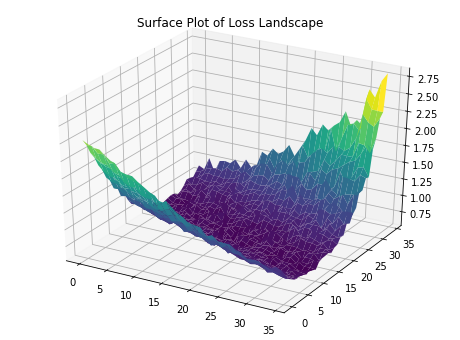

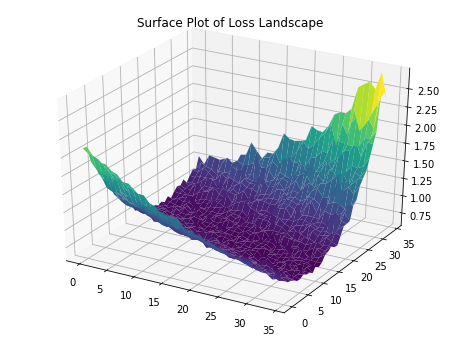

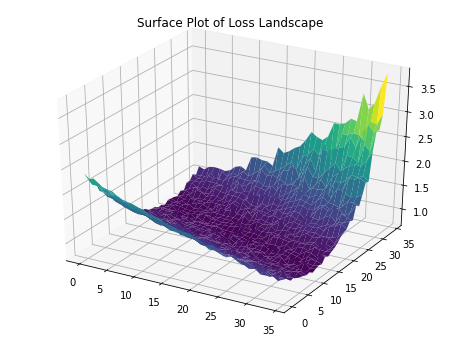

In [ ]:
sgd_loss_land()

##LOSS LAND SCAPE FOR SWA

In [ ]:
def swa_loss_land():
  for i in range(1,11):
    RESUME_POINT = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_{i}/SWA/checkpoint-50.pt'
    model, criterion, optimizer = prep_model_for_loss(MODEL_NAME)
    checkpoint = torch.load(RESUME_POINT)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    # data that the evaluator will use when evaluating loss
    criterion = criterion
    x, y = iter(loaders['train']).__next__()
    metric = loss_landscapes.metrics.Loss(criterion, x, y)

    # compute loss data
    loss_data_fin = loss_landscapes.random_plane(model, metric, distance=15, steps=STEPS, normalization='filter', deepcopy_model=True)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    X = np.array([[j for j in range(STEPS)] for i in range(STEPS)])
    Y = np.array([[i for _ in range(STEPS)] for i in range(STEPS)])
    ax.plot_surface(X, Y, loss_data_fin, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    ax.set_title('Surface Plot of Loss Landscape for SWA')
    fig.show()

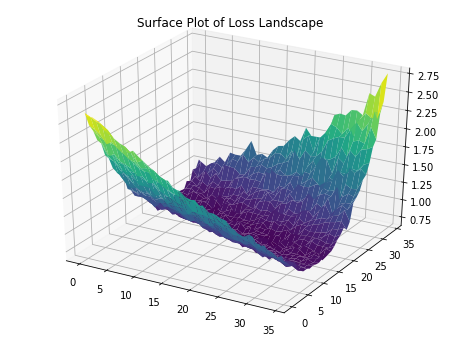

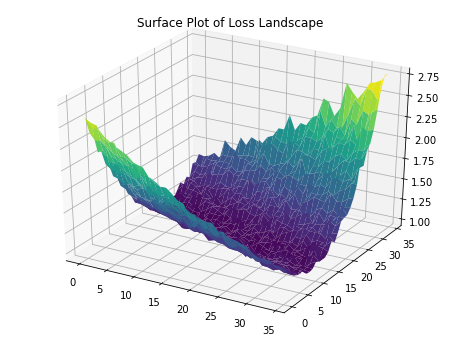

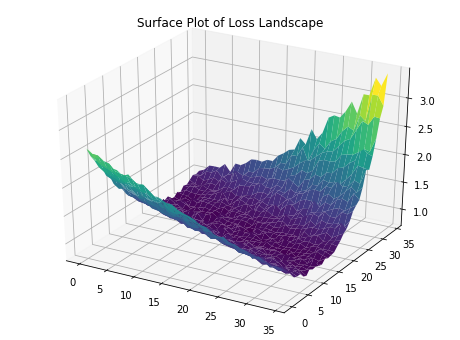

In [ ]:
swa_loss_land()

#Linear Interpolations of Loss between Two Points of SWA and SGD

In [ ]:
def inter_loss():
    swa_point = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_2/SWA/checkpoint-50.pt'
    sgd_point = f'/content/drive/MyDrive/colab_projects_files/dnn-mode-connectivity/Experiment_2/fge/train_for_fge/checkpoint-50.pt'
    #prep swa model
    model_swa, criterion_swa, optimizer_swa = prep_model_for_loss(MODEL_NAME)
    checkpoint = torch.load(swa_point)
    model_swa.load_state_dict(checkpoint['state_dict'])
    optimizer_swa.load_state_dict(checkpoint['optimizer'])
    #prep model sgd
    model_sgd, criterion_sgd, optimizer_sgd = prep_model_for_loss(MODEL_NAME)
    checkpoint = torch.load(sgd_point)
    model_sgd.load_state_dict(checkpoint['model_state'])
    optimizer_sgd.load_state_dict(checkpoint['optimizer_state'])
    # data that the evaluator will use when evaluating loss
    criterion = criterion_swa
    x, y = iter(loaders['train']).__next__()
    metric = loss_landscapes.metrics.Loss(criterion_swa, x, y)

    # compute loss data
    loss_data_swa_to_sgd = loss_landscapes.linear_interpolation(model_swa, model_sgd, metric, STEPS, deepcopy_model=True)
    loss_data_sgd_to_swa = loss_landscapes.linear_interpolation(model_sgd, model_swa, metric, STEPS, deepcopy_model=True)
    return loss_data_swa_to_sgd, loss_data_sgd_to_swa

In [ ]:
STEPS = 35
loss_data_swa_to_sgd, loss_data_sgd_to_swa = inter_loss()

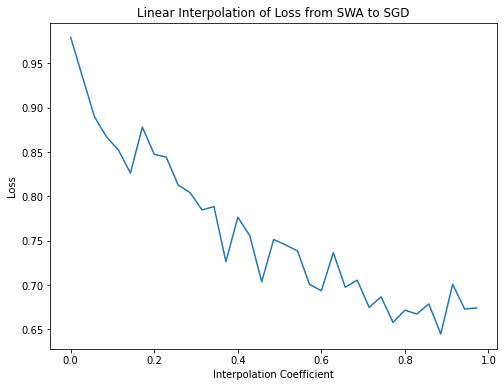

In [ ]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data_swa_to_sgd)
plt.title('Linear Interpolation of Loss from SWA to SGD')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()

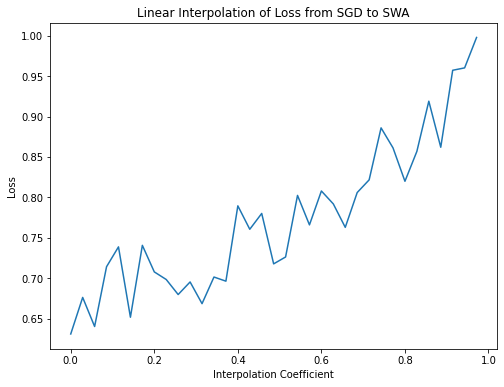

In [ ]:
plt.plot([1/STEPS * i for i in range(STEPS)], loss_data_sgd_to_swa)
plt.title('Linear Interpolation of Loss from SGD to SWA')
plt.xlabel('Interpolation Coefficient')
plt.ylabel('Loss')
axes = plt.gca()
# axes.set_ylim([2.300,2.325])
plt.show()